In [1]:
import sys
import torch 
sys.path.append("src")

In [2]:
from torch.utils.data import DataLoader
from dataloader import CollateFunctionSongDetection, SongDetectorDataClass


collate_fn = CollateFunctionSongDetection(segment_length=4096)

test_class = SongDetectorDataClass("/media/george-vengrovski/disk2/training_song_detector/labeled_song_dataset/test", augment=False)
test_loader = DataLoader(test_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

train_class = SongDetectorDataClass("/media/george-vengrovski/disk2/training_song_detector/labeled_song_dataset/train", augment=False)
train_loader = DataLoader(train_class, batch_size=24, shuffle=True, num_workers=16, collate_fn=collate_fn)

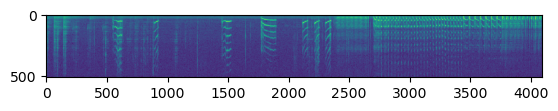

In [3]:
_, s = next(iter(test_loader))
import matplotlib.pyplot as plt

plt.imshow(_[0,0])

In [3]:
from model import TweetyNet
from trainer import Trainer 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

model = TweetyNet(hidden_size=32, rnn_dropout=0.2, num_classes=1, input_shape=(1, 512, 4096))
model = model.to(device)

Using device: cuda


/home/george-vengrovski/anaconda3/envs/tweetybert/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [4]:
trainer = Trainer(model=model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=10, desired_total_batches=200, patience=8)
trainer.train()

Batch 10: FER = 18.26%, Train Loss = 0.5178, Val Loss = 0.5188
Batch 20: FER = 6.47%, Train Loss = 0.3227, Val Loss = 0.3119
Batch 30: FER = 2.69%, Train Loss = 0.1919, Val Loss = 0.1802
Batch 40: FER = 2.78%, Train Loss = 0.1054, Val Loss = 0.1215
Batch 50: FER = 2.51%, Train Loss = 0.2336, Val Loss = 0.1044
Batch 60: FER = 2.55%, Train Loss = 0.0729, Val Loss = 0.0914
Batch 70: FER = 2.58%, Train Loss = 0.1889, Val Loss = 0.0817
Batch 80: FER = 2.16%, Train Loss = 0.1143, Val Loss = 0.0760
Batch 90: FER = 2.47%, Train Loss = 0.0744, Val Loss = 0.0936
Batch 100: FER = 2.36%, Train Loss = 0.1000, Val Loss = 0.0893
Batch 110: FER = 2.94%, Train Loss = 0.0468, Val Loss = 0.0918
Batch 120: FER = 2.44%, Train Loss = 0.0621, Val Loss = 0.0788
Batch 130: FER = 2.45%, Train Loss = 0.0878, Val Loss = 0.0851
Batch 140: FER = 2.52%, Train Loss = 0.0793, Val Loss = 0.0800
Batch 150: FER = 2.63%, Train Loss = 0.0780, Val Loss = 0.0864
Batch 160: FER = 1.89%, Train Loss = 0.0807, Val Loss = 0.0645


In [8]:
from utils import save_model_config_and_weights

config = {
"model_name": "sorter-specs-with-nothreshold-with-LLB-0.1",
"hidden_size": 32,
"context_size": 4096,
"batch_size": 24,
"num_batches_train": 100,
"lr": 3e-4
}

save_model_config_and_weights(trainer, config, config['model_name'])

Model config saved to /home/george-vengrovski/Documents/projects/tweety_net_song_detector/files/sorter-specs-with-nothreshold-0.1/config.json
Model weights saved to /home/george-vengrovski/Documents/projects/tweety_net_song_detector/files/sorter-specs-with-nothreshold-0.1/weights.pth


First 10 logit values: [0.01898846 0.01386398 0.0095037  0.00775597 0.00702019 0.00669309
 0.00638498 0.00611293 0.00595514 0.00578127]


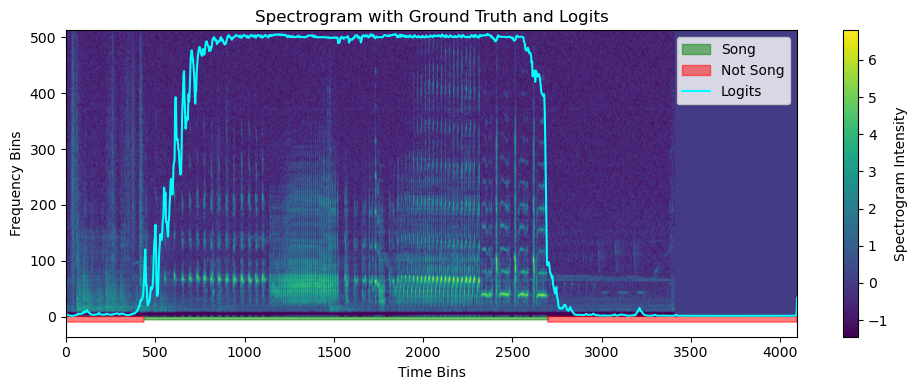

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply softmax to logits to scale them between 0 and 1
    logits_softmax = (logits.squeeze().detach().cpu()).numpy()  # Ensure logits is 1D before applying softmax

    # Print the first 10 logit values
    print("First 10 logit values:", logits_softmax[:10])

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as bars at the bottom
    times = np.arange(ground_truth_label.shape[0])
    song_bar_height = np.full_like(ground_truth_label.numpy(), -5)  # Slightly below the spectrogram
    not_song_bar_height = np.full_like(ground_truth_label.numpy(), -10)  # Further below for clarity

    plt.fill_between(times, song_bar_height, where=ground_truth_label.numpy() > 0.5, color='green', step='mid', alpha=0.5, label='Song')
    plt.fill_between(times, not_song_bar_height, where=ground_truth_label.numpy() <= 0.5, color='red', step='mid', alpha=0.5, label='Not Song')

    # Overlay logits as a line plot
    plt.plot(times, logits_softmax * (spec.shape[0] - 1), color='cyan', label='Logits')  # Scale logits to match spectrogram's frequency range

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `test_loader`, `model`, and `device` are defined and initialized in your code
spec, ground_truth_label = next(iter(test_loader))  # Get a batch from your DataLoader

logit = model(spec.to(device))  # Get model predictions

# Use the first example in the batch for plotting
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logit = logit[0]  # Adjust based on your model's output shape

# Remove channel dimension if present
if spec.dim() > 2:
    spec = spec.squeeze(0)

# Plot using the function
plot_spectrogram_with_labels_and_logits(spec.cpu(), ground_truth_label.cpu(), logit.cpu())


In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm  # Import tqdm for progress tracking


def process_spectrogram(spec, max_length=2048):
    """
    Process the spectrogram in chunks, pass through the classifier, and return the binary predictions based on BCE.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(spec.shape[1] / max_length))
    combined_predictions = []

    for i in range(num_chunks):
        # Extract the chunk
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, spec.shape[1])
        chunk = spec[:, start_idx:end_idx]
        # Forward pass through the model
        # Ensure chunk is on the correct device
        chunk_tensor = torch.Tensor(chunk).unsqueeze(0).unsqueeze(0).to(device)
        
        logits = model(chunk_tensor)
        logits = logits.squeeze().detach().cpu()

        combined_predictions.append(logits)

    # Concatenate all chunks' predictions
    final_predictions = np.concatenate(combined_predictions, axis=-1)

    return final_predictions

def process_files(src):
    """
    Process each file in the directory, reshape predictions, and overwrite the original files with the processed data.
    """
    files = os.listdir(src)
    for file in tqdm(files, desc="Processing files"):  # Wrap the loop with tqdm for progress tracking
        file_path = os.path.join(src, file)

        try:
            # Load the spectrogram from the file
            f = np.load(file_path, allow_pickle=True)
            spec = f['s']

            # Z-score normalization
            spec_mean = spec.mean()
            spec_std = spec.std()
            spec = (spec - spec_mean) / spec_std

            # Process the spectrogram and get predictions
            predictions = process_spectrogram(spec)

            # Overwrite the original file with the spectrogram and predictions
            np.savez(file_path, s=spec, song=predictions)  # Use the original `file_path` to overwrite

        except Exception as e:
            print(f"Failed to process file {file}: {str(e)}")

src = "/media/george-vengrovski/disk1/usa_5288/usa_5288_test"
process_files(src)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def moving_average(signal, window_size):
    """Compute the moving average of the given signal with the specified window size."""
    cumsum_vec = np.cumsum(np.insert(signal, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

def post_process_segments(smoothed_song, threshold, min_length, pad_song):
    """Post-process the smoothed song to adjust segments shorter than min_length and apply padding."""
    processed_song = np.zeros_like(smoothed_song)
    above_threshold = smoothed_song >= threshold
    start = None

    for i, value in enumerate(above_threshold):
        if value and start is None:
            start = i  # Mark the start of a new segment
        elif not value and start is not None:
            # Segment end found; check if it meets the min_length requirement
            if i - start >= min_length:
                # Apply padding to segments that meet the min_length requirement
                start_pad = max(start - pad_song, 0)  # Ensure start_pad is not less than 0
                end_pad = min(i + pad_song, len(above_threshold))  # Ensure end_pad does not exceed array length
                processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]
            start = None  # Reset start for the next segment

    # Handle the case where a segment extends to the end of the array
    if start is not None and len(above_threshold) - start >= min_length:
        start_pad = max(start - pad_song, 0)
        end_pad = min(len(above_threshold) + pad_song, len(above_threshold))
        processed_song[start_pad:end_pad] = smoothed_song[start_pad:end_pad]

    return processed_song

def plot_with_classification_line(src, output_dir, threshold=0.5, min_length=500, pad_song=50):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(src)

    for file_name in files:
        file_path = os.path.join(src, file_name)
        f = np.load(file=file_path, allow_pickle=True)
        song = f['song']

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.imshow(f['s'], aspect='auto', origin='lower')
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')

        # Compute and plot smoothed line
        smoothed_song = moving_average(song, window_size=100)
        smoothed_times = np.arange(len(smoothed_song)) + 50  # Offset for alignment
        ax.plot(smoothed_times, smoothed_song * (f['s'].shape[0] - 1), color='magenta', label='Smoothed Classification Sigmoid', alpha=0.7)

        # Post-process smoothed song to adjust short segments and apply padding
        processed_song = post_process_segments(smoothed_song, threshold, min_length, pad_song)

        # Add a color bar below the spectrogram based on the processed song data
        for i in range(len(processed_song)):
            color = 'red' if processed_song[i] > 0 else 'blue'
            ax.axhspan(ymin=-5, ymax=0, xmin=(i + 50) / len(song), xmax=(i + 51) / len(song), color=color)

        ax.set_ylim(bottom=-5)  # Adjust y-axis to include the new bar

        # Adjust legend to include both lines
        ax.legend(loc='upper right')

        # Saving the plot
        output_file_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_detection.png")
        plt.savefig(output_file_path, bbox_inches='tight')
        plt.close(fig)

# Example usage
src = "/media/george-vengrovski/disk1/usa_5288/usa_5288_test"
output_dir = "/media/george-vengrovski/disk2/training_song_detector/labeled_song_dataset/imgs"
plot_with_classification_line(src, output_dir, threshold=0.5, min_length=500, pad_song=50)